In [ ]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [ ]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\简单插值\\原始数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet2') 
print(df_sheet.info())
print(df_sheet.columns)


In [ ]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量', '上小时喷煤量']
output_term = ['SI']
time_term= '时间戳'


In [ ]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[6]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[0]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




In [ ]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r*-', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 800
start1 = 0
length2 = 800
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [ ]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    input_term[4]:   df_sheet_process[input_term[4]].values,
    input_term[5]:   df_sheet_process[input_term[5]].values,
    input_term[6]:   df_sheet_process[input_term[6]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [ ]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)




In [ ]:
isShuffle = True
# isShuffle = False


In [86]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data
    u5_data = u5_data
    u6_data = u6_data
    u7_data = u7_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)
    u5_data_1 = np.roll(u5_data, 1)
    u6_data_1 = np.roll(u6_data, 1)
    u7_data_1 = np.roll(u7_data, 1)

    y1_data = y1_data
    y2_data = y2_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1], u5_data  [1:-1], u6_data  [1:-1], u7_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1], u5_data_1[1:-1], u6_data_1[1:-1], u7_data_1[1:-1],
                            y1_data  [1:-1])
                        )
    y = y1_data[2:]

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], X.shape[1]))
    y_reshaped = y
    print('总数据数量：',y.shape)




    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)




    # y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    # y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    # y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [88]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
u5_data = normalized_data_dict[input_term[4]][index_gaolu]
u6_data = normalized_data_dict[input_term[5]][index_gaolu]
u7_data = normalized_data_dict[input_term[6]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = y1_data
num_samples = y1_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data)


高炉模型数据
总数据数量： (799,)
训练数量： (559, 15) (559,)
验证数量： (120, 15) (120,)
测试数量： (120, 15) (120,)


In [89]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [90]:
epoch_once_time = 30


In [91]:
# 建立高炉模型实例
input_size = 15  # 输入特征大小
hidden_size = 20  # 隐藏层大小
output_size = 1  # 输出大小

# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyNeuralNetwork(input_size, hidden_size, output_size)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


第 30/30 轮, 训练误差: 1.4937, 验证误差: 1.3405
epoch_sum: 30


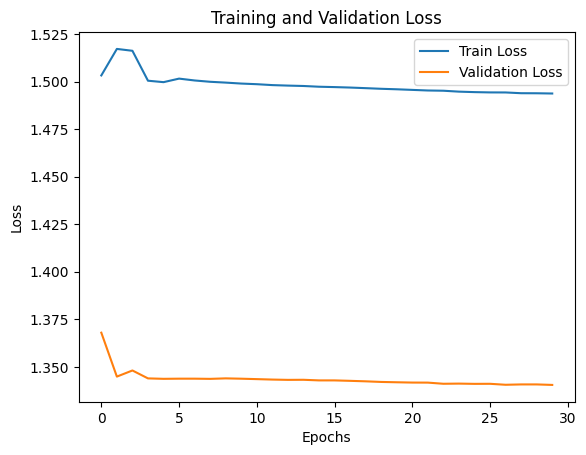

In [92]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



RMSE:  铁口1温度: 16.7576
MAPE:  铁口1温度: 0.8614% 
MRE :  铁口1温度: 0.0086
per :  铁口1温度: 0.0072


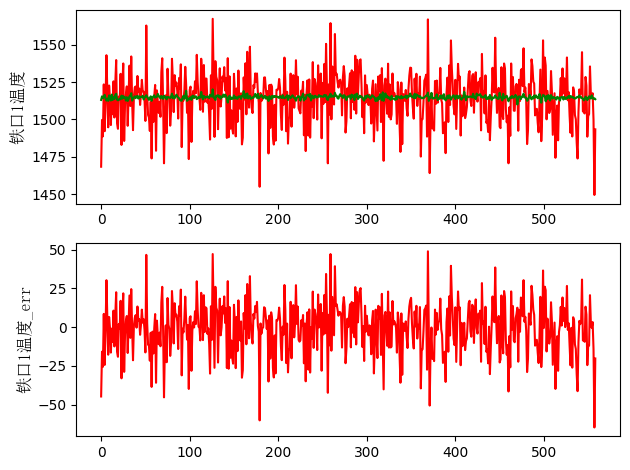

In [93]:
# 高炉模型预测
y_pred_0 = model_gaolu.my_predict(X_gaolu_train)
# 计算 RMSE、MRE
y_test = y_gaolu_train
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]




y_test_0 = scalers[output_term[0]].inverse_transform((y_test).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100

percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 0.1)/len(y_test_0)
# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f}")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% ")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}")
print(f"per :  {output_term[0]}: { percent0:.4f}")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



RMSE:  铁口1温度: 19.0146
MAPE:  铁口1温度: 0.9610% 
MRE :  铁口1温度: 0.0096
per :  铁口1温度: 0.0000


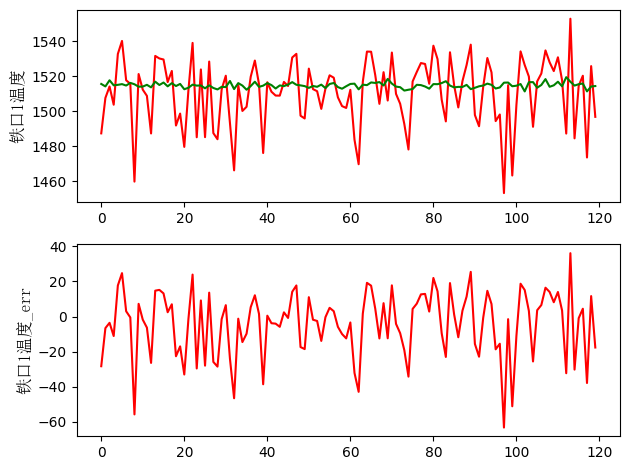

In [94]:
# 高炉模型预测
y_pred_0 = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test
# y_test = y_test[:70]
# y_pred_0 = y_pred_0[:70]
# y_pred_1 = y_pred_1[:70]




y_test_0 = scalers[output_term[0]].inverse_transform((y_test).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100

percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 0.1)/len(y_test_0)
# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f}")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% ")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}")
print(f"per :  {output_term[0]}: { percent0:.4f}")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [82]:
# 创建预测模型实例
input_size = 16  # 输入特征大小
hidden_size = 20  # 隐藏层大小
output_size = 2  # 输出大小

# 设置随机种子
torch.manual_seed(0)
model_predict = MyNeuralNetwork(input_size, hidden_size, output_size)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


In [83]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model_predict.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x15 and 16x20)

In [ ]:
# 预测模型预测
y_pred_0,y_pred_1  = model_predict.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test







y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

percent0 = np.sum(np.fabs(y_test_0 - y_pred_0_inverse_transform) < 10)/len(y_test_0)
percent1 = np.sum(np.fabs(y_test_1 - y_pred_1_inverse_transform) < 0.1)/len(y_test_1)
# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")
print(f"per :  {output_term[0]}: { percent0:.4f}  , {output_term[1]}: { percent1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [ ]:
y_test = y_predict_test
y_test_0 = scalers[output_term[0]].inverse_transform(y_predict_test[:,0].reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform(y_predict_test[:,1].reshape(-1, 1)).flatten()
y_pred_0,y_pred_1  = model_predict.my_predict(X_predict_test)
y_pred_0_predict = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_predict = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

y_pred_0,y_pred_1  = model_gaolu.my_predict(X_predict_test)
y_pred_0_gaolu = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_gaolu = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

plt.subplot(2, 1, 1)
plt.plot(y_test_0, 'r-', label='Actual')
plt.plot(y_pred_0_predict, 'g-', label='Predict')
plt.plot(y_pred_0_gaolu, 'b', label='Gaolu')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_1, 'r-', label='Actual')
plt.plot(y_pred_1_predict, 'g-', label='Predict')
plt.plot(y_pred_1_gaolu, 'b', label='Gaolu')
plt.legend()

